C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_17308\2986688935.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Profit'].iloc[0] = 0
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_17308\2986688935.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Profit'].iloc[point] = profit[i]
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_17308\2986688935.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

최종 자산은 86.4311355764593 입니다.
최종 수익률은 -13.568864423540703 % 입니다.


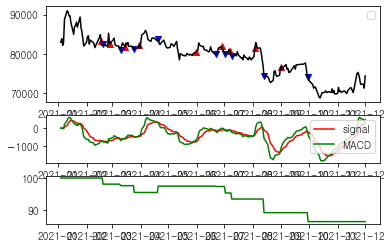

In [3]:
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import font_manager, rc

# 한글 폰트 사용
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 오늘 날짜 자동 설정
#today = datetime.date.today()

#데이터 가져오기
df = web.get_data_yahoo('005930.KS', '2021-01-01', '2021-12-01')

# MACD 계산에 필요한 값을 데이터프레임에 넣기
def MACD(df):
    df['EMA12'] = df.Close.ewm(span=12).mean()
    df['EMA26'] = df.Close.ewm(span=26).mean()
    df['MACD'] = df.EMA12 - df.EMA26
    df['signal'] = df.MACD.ewm(span=9).mean()

# MACD 함수 실행
MACD(df)

Buy, Sell = [], []

# 정확한 신호를 위해 26일 이평선이 나오고 나서부터 매수매도 시점을 찾는다
for i in range(26, len(df)):
    if df.MACD.iloc[i] > df.signal.iloc[i] and df.MACD.iloc[i - 1] < df.signal.iloc[i - 1]:
        Buy.append(i)
    elif df.MACD.iloc[i] < df.signal.iloc[i] and df.MACD.iloc[i - 1] > df.signal.iloc[i - 1]:
        Sell.append(i)

# 실제 매수매도는 신호가 나온 다음날에 하기떄문에 다음날로 지정
buy_point = [i + 1 for i in Buy]
sell_point = [i + 1 for i in Sell]

# 매수보다 매도가 빠르거나 마지막에 매도로 끝나지 않고 매수로 끝날 시 그 부분 삭제
if sell_point[0] < buy_point[0]:
    del sell_point[0]
if buy_point[-1] > sell_point[-1]:
    del buy_point[-1]

# 장이 열리자마자 시가에 매수매도
buy_price = df.Open.iloc[buy_point]
sell_price = df.Open.iloc[sell_point]

profit = []

for i in range(len(sell_price)):
    profit.append((sell_price[i] - buy_price[i]) / buy_price[i])

# 데이터프레임에 수익률을 넣는다.
df['Profit'] = ''
df['Profit'].iloc[0] = 0
for i, point in enumerate(sell_point):
    df['Profit'].iloc[point] = profit[i]
df = df.replace('', 0)

# 데이터프레임에 자산 변동을 넣는다.
df['Asset'] = ''
df['Asset'].iloc[0] = 100
for i in range(1, len(df)):
    if df['Profit'].iloc[i] == 0:
        df['Asset'].iloc[i] = df['Asset'].iloc[i-1]
    else:
        df['Asset'].iloc[i] = df['Asset'].iloc[i-1] + df['Asset'].iloc[i-1] * df['Profit'].iloc[i]

print("최종 자산은", df['Asset'].iloc[-1], "입니다.")
print("최종 수익률은", df['Asset'].iloc[-1] - 100 / 100 * 100, "% 입니다.")

# 그래프
fig = plt.figure()
spec = gridspec.GridSpec(ncols=1, nrows=3, height_ratios=[2, 1, 1])

# 주가 그래프에 매수매도시점 표시하기
ax0 = plt.subplot(spec[0])
plt.scatter(df.iloc[buy_point].index, df.iloc[buy_point].Close, marker='^', color='red')
plt.scatter(df.iloc[sell_point].index, df.iloc[sell_point].Close, marker='v', color='blue')
plt.plot(df.Close, color='k')
plt.legend()

# MACD 그래프
ax1 = plt.subplot(spec[1])
plt.plot(df.signal, label='signal', color='red')
plt.plot(df.MACD, label='MACD', color='green')
plt.legend()

# 자산 그래프
ax2 = plt.subplot(spec[2])
plt.plot(df.Asset, label='Asset', color='green')

plt.show()